# Factors contributing to batting collapse in Test Cricket. (ICC WTC 24-25)


## Importing libraries
This section imports all the required Python libraries for data analysis, visualization, and hypothesis testing.


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind, chi2_contingency

sns.set(style="whitegrid")

## Data Exploration

### Loading and Exploring data
Loading up the datasets and performing initial exploration to understand structure of the dataset and its features.

In [ ]:
deliveries_df = pd.read_csv('/content/deliveries.csv')
matches_df = pd.read_csv('/content/matches.csv')
points_table_df = pd.read_csv('/content/points_table.csv')

print("Deliveries Dataset:")
print(deliveries_df.head())

print("\nMatches Dataset:")
print(matches_df.head())

print("\nPoints Table Dataset:")
print(points_table_df.head())


Deliveries Dataset:
   match_id   season  start_date                     venue  innings  ball  \
0   1375843  2023/24  2023-12-26  Melbourne Cricket Ground        1   0.1   
1   1375843  2023/24  2023-12-26  Melbourne Cricket Ground        1   0.2   
2   1375843  2023/24  2023-12-26  Melbourne Cricket Ground        1   0.3   
3   1375843  2023/24  2023-12-26  Melbourne Cricket Ground        1   0.4   
4   1375843  2023/24  2023-12-26  Melbourne Cricket Ground        1   0.5   

  batting_team bowling_team     striker non_striker  ... extras  wides  \
0    Australia     Pakistan   DA Warner  UT Khawaja  ...      0    NaN   
1    Australia     Pakistan   DA Warner  UT Khawaja  ...      0    NaN   
2    Australia     Pakistan   DA Warner  UT Khawaja  ...      0    NaN   
3    Australia     Pakistan  UT Khawaja   DA Warner  ...      0    NaN   
4    Australia     Pakistan  UT Khawaja   DA Warner  ...      0    NaN   

   noballs  byes  legbyes  penalty  wicket_type  player_dismissed  \
0  

### Exploratory Data Analysis (EDA)
Performing EDA on the deliveries_df, matches_df and points_table_df to uncover patterns and trends, including visualizations


In [ ]:
print("\nMissing Values in Deliveries:")
print(deliveries_df.isnull().sum())

print("\nStatistical Summary of Deliveries:")
print(deliveries_df.describe())

print("\nMissing Values in Matches:")
print(matches_df.isnull().sum())

print("\nStatistical Summary of Matches:")
print(matches_df.describe())

print("\nMissing Values in Points Table:")
print(points_table_df.isnull().sum())

print("\nStatistical Summary of Points Table:")
print(points_table_df.describe())


Missing Values in Deliveries:
match_id                      0
season                        0
start_date                    0
venue                         0
innings                       0
ball                          0
batting_team                  0
bowling_team                  0
striker                       0
non_striker                   0
bowler                        0
runs_off_bat                  0
extras                        0
wides                     70187
noballs                   69965
byes                      70084
legbyes                   69849
penalty                   70349
wicket_type               68936
player_dismissed          68936
other_wicket_type         70349
other_player_dismissed    70349
dtype: int64

Statistical Summary of Deliveries:
           match_id       innings          ball  runs_off_bat        extras  \
count  7.034900e+04  70349.000000  70349.000000  70349.000000  70349.000000   
mean   1.389040e+06      2.254488     43.009653      0.562

Creating a wicket indicator column. Plotting it on graph to showcase distributing of wickets per innings.

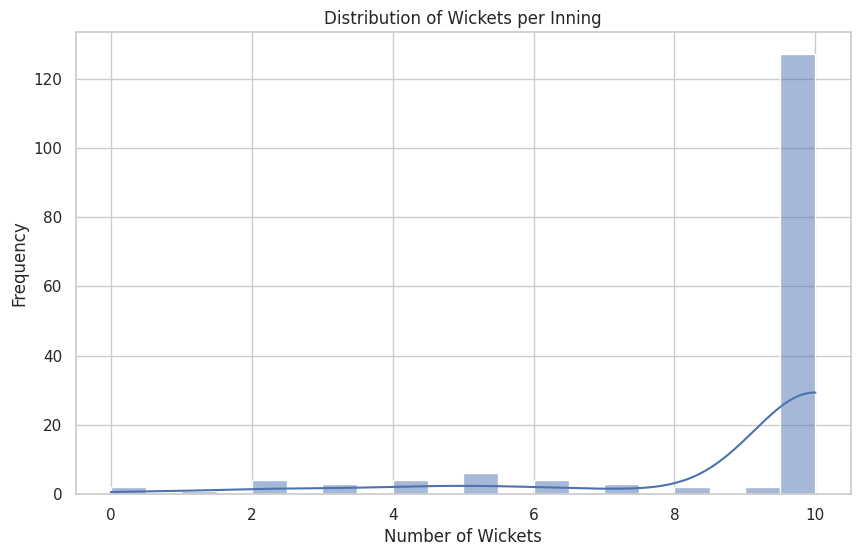

In [ ]:
deliveries_df['wicket'] = deliveries_df['player_dismissed'].notnull().astype(int)
wickets_per_inning = deliveries_df.groupby(['match_id', 'innings'])['wicket'].sum().reset_index()

plt.figure(figsize=(10, 6))
sns.histplot(wickets_per_inning['wicket'], bins=20, kde=True, color='b')
plt.title("Distribution of Wickets per Inning")
plt.xlabel("Number of Wickets")
plt.ylabel("Frequency")
plt.show()


Calculating runss per over to visialize change in run rate over the innings and different phases of match.

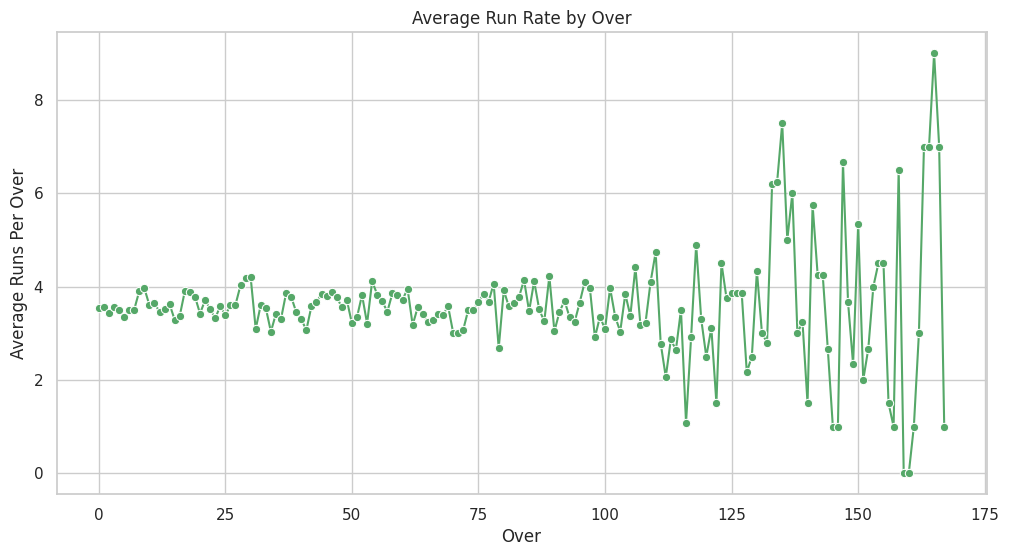

In [ ]:
deliveries_df['over'] = deliveries_df['ball'].apply(lambda x: int(x))
deliveries_df['runs_per_over'] = (deliveries_df['runs_off_bat'] + deliveries_df['extras'])

run_rate_by_over = deliveries_df.groupby(['match_id', 'innings', 'over'])['runs_per_over'].sum().reset_index()
avg_run_rate_by_over = run_rate_by_over.groupby('over')['runs_per_over'].mean().reset_index()

plt.figure(figsize=(12, 6))
sns.lineplot(data=avg_run_rate_by_over, x='over', y='runs_per_over', marker='o', color='g')
plt.title("Average Run Rate by Over")
plt.xlabel("Over")
plt.ylabel("Average Runs Per Over")
plt.show()

### Preprocessing Tasks
Cleaning the data of any anomalies or outliers while also handle missing values, encode categorical data, and create a collapse indicator. (As this data is scrapped from ESPN, there were not any missing value or outlier. There were null values because of no event on that ball. I only had to create new columns for indicators)

In [ ]:
if 'player_dismissed' in deliveries_df.columns:
    deliveries_df['wicket'] = deliveries_df['player_dismissed'].notnull().astype(int)
else:
    print("Error: 'player_dismissed' column is missing from deliveries_df.")

deliveries_df['rolling_wickets'] = deliveries_df['wicket'].rolling(window=60).sum()
deliveries_df['collapse'] = (deliveries_df['rolling_wickets'] >= 3).astype(int)


deliveries_df['runs_off_bat'] = deliveries_df['runs_off_bat'].fillna(0)

deliveries_df['batting_team'] = deliveries_df['batting_team'].astype('category').cat.codes
deliveries_df['bowling_team'] = deliveries_df['bowling_team'].astype('category').cat.codes

print("\nUpdated DataFrame Sample:")
print(deliveries_df[['wicket', 'rolling_wickets', 'collapse', 'batting_team', 'bowling_team']].head())



Updated DataFrame Sample:
   wicket  rolling_wickets  collapse  batting_team  bowling_team
0       0              NaN         0             0             5
1       0              NaN         0             0             5
2       0              NaN         0             0             5
3       0              NaN         0             0             5
4       0              NaN         0             0             5


## Hypothesis Testing
This section validates hypotheses estabilshed
1. Run rate drop before collapse
2. Second innings pressure


### Hypothesis 1 : Run Rate Drops Precede Collapses

In [ ]:
collapse_run_rates = deliveries_df['over'] = deliveries_df['ball'].apply(lambda x: int(x))
non_collapse_run_rates = deliveries_df['runs_per_over'] = (deliveries_df['runs_off_bat'] + deliveries_df['extras'])

t_stat, p_value = ttest_ind(collapse_run_rates, non_collapse_run_rates, equal_var=False)

print("\nHypothesis 1: Run Rate Drops Precede Collapses")
print(f"T-test Results: t-statistic = {t_stat:.2f}, p-value = {p_value:.4f}")

if p_value < 0.05:
    print("Result: Statistically significant. Run rates are lower during collapse phases.")
else:
    print("Result: Not statistically significant. No evidence that run rates differ during collapse phases.")



Hypothesis 1: Run Rate Drops Precede Collapses
T-test Results: t-statistic = 367.13, p-value = 0.0000
Result: Statistically significant. Run rates are lower during collapse phases.


### Hypothesis 2: Collapses Are More Frequent in the Second Innings

In [ ]:
first_innings_collapses = deliveries_df[(deliveries_df['innings'] == 1) & (deliveries_df['collapse'] == 1)].shape[0]
second_innings_collapses = deliveries_df[(deliveries_df['innings'] == 2) & (deliveries_df['collapse'] == 1)].shape[0]

contingency_table = np.array([[first_innings_collapses, second_innings_collapses]])

chi2_stat, p_value, dof, expected = chi2_contingency(contingency_table)

print("\nHypothesis 3: Collapses Are More Frequent in the Second Innings")
print(f"Chi-Square Test Results: chi2 = {chi2_stat:.2f}, p-value = {p_value:.4f}")

if p_value < 0.05:
    print("Result: Statistically significant. Collapses are more frequent in the second innings.")
else:
    print("Result: Not statistically significant. No evidence that collapses are more frequent in the second innings.")



Hypothesis 3: Collapses Are More Frequent in the Second Innings
Chi-Square Test Results: chi2 = 0.00, p-value = 1.0000
Result: Not statistically significant. No evidence that collapses are more frequent in the second innings.


## ML Model

Importing modules required.

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import time

### Logistic Regression

Logistic regression estimates the probability of an event occurring, such as voted or didn't vote, based on a given data set of independent variables.

Step 1: Prepare the data for modeling

In [ ]:
features = ['batting_team', 'bowling_team', 'rolling_wickets', 'runs_per_over', 'innings']
target = 'collapse'

model_data = deliveries_df[features + [target]].dropna()

X = model_data[features]
y = model_data[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,stratify=y, random_state=42)

Step 2: Train Logistic Regression Model


In [ ]:
logreg_model = LogisticRegression()

start_time = time.time()
logreg_model.fit(X_train, y_train)
end_time = time.time()
lr_training_time = end_time - start_time
print(f"Logistic Regression Training Time: {lr_training_time:.2f} seconds")

Logistic Regression Training Time: 0.13 seconds


Step 3: Evaluate the Model


In [ ]:
y_train_pred = logreg_model.predict(X_train)
y_test_pred = logreg_model.predict(X_test)

train_accuracy_ls = accuracy_score(y_train, y_train_pred)
test_accuracy_ls = accuracy_score(y_test, y_test_pred)

print(f"Training Accuracy: {train_accuracy_ls:.2f}")
print(f"Test Accuracy: {test_accuracy_ls:.2f}")

print("\nClassification Report (Test Data):")
print(classification_report(y_test, y_test_pred))

print("\nConfusion Matrix (Test Data):")
print(confusion_matrix(y_test, y_test_pred))

Training Accuracy: 1.00
Test Accuracy: 1.00

Classification Report (Test Data):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     12171
           1       1.00      1.00      1.00      1887

    accuracy                           1.00     14058
   macro avg       1.00      1.00      1.00     14058
weighted avg       1.00      1.00      1.00     14058


Confusion Matrix (Test Data):
[[12171     0]
 [    0  1887]]


### Random Forest


Initialize and Training Random Forest Model

In [ ]:
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

start_time = time.time()
rf_model.fit(X_train, y_train)
end_time = time.time()
rf_training_time = end_time - start_time
print(f"Random Forest Training Time: {rf_training_time:.2f} seconds")

Random Forest Training Time: 1.30 seconds


Predict on train and test sets

In [ ]:
y_train_pred_rf = rf_model.predict(X_train)
y_test_pred_rf = rf_model.predict(X_test)

train_accuracy_rf = accuracy_score(y_train, y_train_pred_rf)
test_accuracy_rf = accuracy_score(y_test, y_test_pred_rf)

print(f"Random Forest Training Accuracy: {train_accuracy_rf:.2f}")
print(f"Random Forest Test Accuracy: {test_accuracy_rf:.2f}")

print("\nClassification Report (Test Data):")
print(classification_report(y_test, y_test_pred_rf))

print("\nConfusion Matrix (Test Data):")
print(confusion_matrix(y_test, y_test_pred_rf))

Random Forest Training Accuracy: 1.00
Random Forest Test Accuracy: 1.00

Classification Report (Test Data):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     12171
           1       1.00      1.00      1.00      1887

    accuracy                           1.00     14058
   macro avg       1.00      1.00      1.00     14058
weighted avg       1.00      1.00      1.00     14058


Confusion Matrix (Test Data):
[[12171     0]
 [    0  1887]]


### XGBoost Classifier

Initialize and Train XGBoost Model

In [ ]:
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

start_time = time.time()
xgb_model.fit(X_train, y_train)
end_time = time.time()
xgb_training_time = end_time - start_time
print(f"XGBoost Training Time: {xgb_training_time:.2f} seconds")

XGBoost Training Time: 0.19 seconds


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:17:21] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Predict on train and test sets

In [ ]:
y_train_pred_xgb = xgb_model.predict(X_train)
y_test_pred_xgb = xgb_model.predict(X_test)

train_accuracy_xgb = accuracy_score(y_train, y_train_pred_xgb)
test_accuracy_xgb = accuracy_score(y_test, y_test_pred_xgb)

print(f"XGBoost Training Accuracy: {train_accuracy_xgb:.2f}")
print(f"XGBoost Test Accuracy: {test_accuracy_xgb:.2f}")

print("\nClassification Report (Test Data):")
print(classification_report(y_test, y_test_pred_xgb))

print("\nConfusion Matrix (Test Data):")
print(confusion_matrix(y_test, y_test_pred_xgb))


XGBoost Training Accuracy: 1.00
XGBoost Test Accuracy: 1.00

Classification Report (Test Data):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     12171
           1       1.00      1.00      1.00      1887

    accuracy                           1.00     14058
   macro avg       1.00      1.00      1.00     14058
weighted avg       1.00      1.00      1.00     14058


Confusion Matrix (Test Data):
[[12171     0]
 [    0  1887]]


Hyperparameter Tuning

Logistic Regression

In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10]
}

grid_search = GridSearchCV(estimator=RandomForestClassifier(random_state=42),
                           param_grid=param_grid,
                           cv=3,
                           scoring='accuracy')
grid_search.fit(X_train, y_train)

print("Best Parameters for Random Forest:")
print(grid_search.best_params_)

best_rf_model = grid_search.best_estimator_
y_test_pred_best_rf = best_rf_model.predict(X_test)
print(f"Best Random Forest Test Accuracy: {accuracy_score(y_test, y_test_pred_best_rf):.2f}")

Best Parameters for Random Forest:
{'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 50}
Best Random Forest Test Accuracy: 1.00


XGBoost

In [ ]:
# from sklearn.model_selection import GridSearchCV
# from xgboost import XGBClassifier
# import numpy as np

# param_grid = {
#     'n_estimators': [50, 100, 200],
#     'max_depth': [3, 5, 7],
#     'learning_rate': [0.01, 0.1, 0.2],
#     'subsample': [0.6, 0.8, 1.0],
#     'colsample_bytree': [0.6, 0.8, 1.0],
#     'gamma': [0, 1, 5],
#     'scale_pos_weight': [1, 10, 20]
# }

# grid_search = GridSearchCV(
#     estimator=xgb_model,
#     param_grid=param_grid,
#     scoring='f1',
#     cv=3,
#     verbose=1,
#     n_jobs=-1
# )

# print("Starting Grid Search...")
# grid_search.fit(X_train, y_train)

# print("\nBest Hyperparameters:")
# print(grid_search.best_params_)

# print("\nBest F1 Score:")
# print(grid_search.best_score_)


Starting Grid Search...
Fitting 3 folds for each of 2187 candidates, totalling 6561 fits


KeyboardInterrupt: 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Adding new features

In [ ]:
deliveries_df['recent_run_rate'] = deliveries_df['runs_per_over'].rolling(window=5).mean().fillna(0)

Cross Validation

In [ ]:
from sklearn.model_selection import cross_val_score

cv_scores = cross_val_score(logreg_model, X, y, cv=5, scoring='accuracy')
print(f"Cross-Validation Scores: {cv_scores}")
print(f"Mean CV Accuracy: {np.mean(cv_scores):.2f}")


Cross-Validation Scores: [1. 1. 1. 1. 1.]
Mean CV Accuracy: 1.00


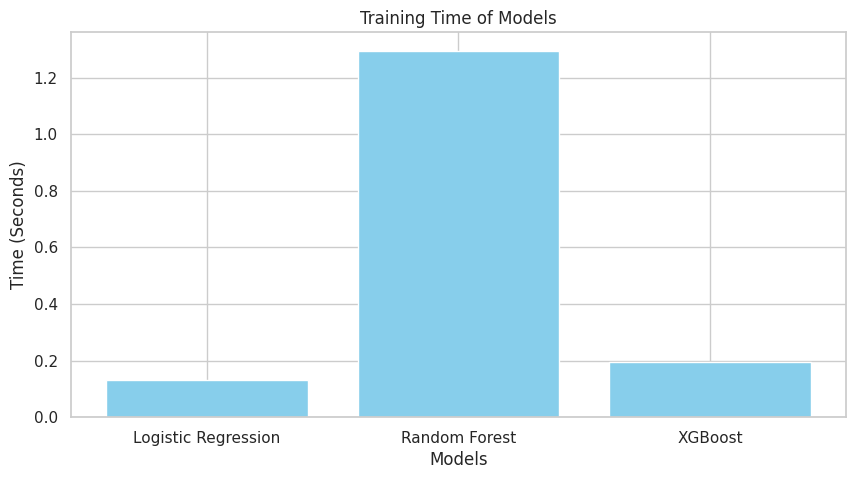

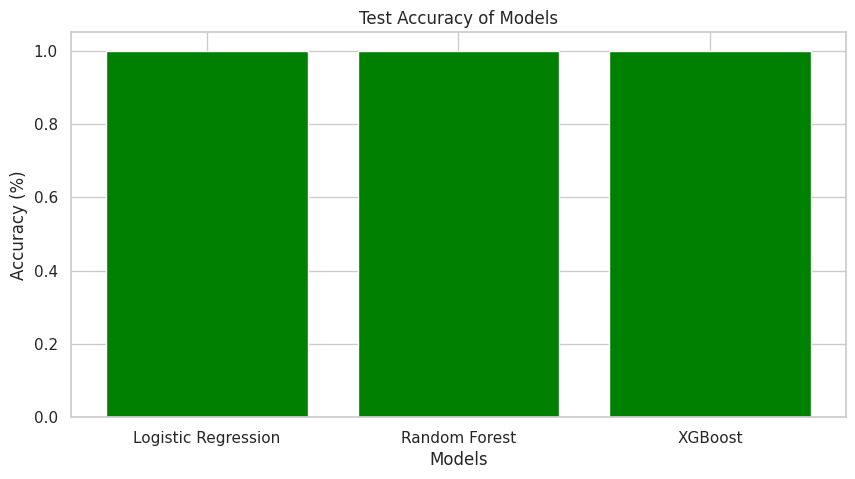

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

models = ['Logistic Regression', 'Random Forest', 'XGBoost']
training_time = [lr_training_time, rf_training_time, xgb_training_time]
test_accuracy = [test_accuracy_ls, test_accuracy_rf, test_accuracy_xgb]


plt.figure(figsize=(10, 5))
plt.bar(models, training_time, color='skyblue')
plt.title('Training Time of Models')
plt.ylabel('Time (Seconds)')
plt.xlabel('Models')
plt.show()

plt.figure(figsize=(10, 5))
plt.bar(models, test_accuracy, color='green')
plt.title('Test Accuracy of Models')
plt.ylabel('Accuracy (%)')
plt.xlabel('Models')
plt.show()


## Scaling

Scaling

In [ ]:
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
import time

pca = PCA(n_components=5)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)



logreg_pca = LogisticRegression(max_iter=500)

start_time = time.time()
logreg_pca.fit(X_train_pca, y_train)
logreg_pca_training_time = time.time() - start_time

logreg_y_test_pred_pca = logreg_pca.predict(X_test_pca)
logreg_y_train_pred_pca = logreg_pca.predict(X_train_pca)

logreg_pca_train_accuracy = accuracy_score(y_train, logreg_y_train_pred_pca)
logreg_pca_test_accuracy = accuracy_score(y_test, logreg_y_test_pred_pca)


rf_model_pca = RandomForestClassifier(n_estimators=100, random_state=42)

start_time = time.time()
rf_model_pca.fit(X_train_pca, y_train)
rf_pca_training_time = time.time() - start_time

rf_pca_y_test_pred = rf_model_pca.predict(X_test_pca)
rf_pca_y_train_pred = rf_model_pca.predict(X_train_pca)

rf_pca_train_accuracy = accuracy_score(y_train, y_train_pred_rf)
rf_pca_test_accuracy = accuracy_score(y_test, rf_pca_y_test_pred)

xgb_model_pca = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

start_time = time.time()
xgb_model_pca.fit(X_train_pca, y_train)
xgb_pca_training_time = time.time() - start_time

xgb_pca_y_train_pred = xgb_model_pca.predict(X_train_pca)
xgb_pca_y_test_pred = xgb_model_pca.predict(X_test_pca)

xgb_pca_train_accuracy = accuracy_score(y_train, xgb_pca_y_train_pred )
xgb_pca_test_accuracy = accuracy_score(y_test, xgb_pca_y_test_pred)

print("PCA Training Time using LR: {:.2f} seconds".format(logreg_pca_training_time))
print("PCA Train Accuracy using LR: {:.2f}".format(logreg_pca_train_accuracy))
print("PCA Test Accuracy using LR: {:.2f}".format(logreg_pca_test_accuracy))

print("PCA Training Time using RF: {:.2f} seconds".format(rf_pca_training_time))
print("PCA Train Accuracy using RF: {:.2f}".format(rf_pca_train_accuracy))
print("PCA Test Accuracy using RF: {:.2f}".format(rf_pca_test_accuracy))

print("PCA Training Time using XGBoost: {:.2f} seconds".format(xgb_pca_training_time))
print("PCA Train Accuracy using XGBoost: {:.2f}".format(xgb_pca_train_accuracy))
print("PCA Test Accuracy using XGBoost: {:.2f}".format(xgb_pca_test_accuracy))


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:18:53] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


PCA Training Time using LR: 0.08 seconds
PCA Train Accuracy using LR: 1.00
PCA Test Accuracy using LR: 1.00
PCA Training Time using RF: 4.59 seconds
PCA Train Accuracy using RF: 1.00
PCA Test Accuracy using RF: 1.00
PCA Training Time using XGBoost: 0.22 seconds
PCA Train Accuracy using XGBoost: 1.00
PCA Test Accuracy using XGBoost: 1.00


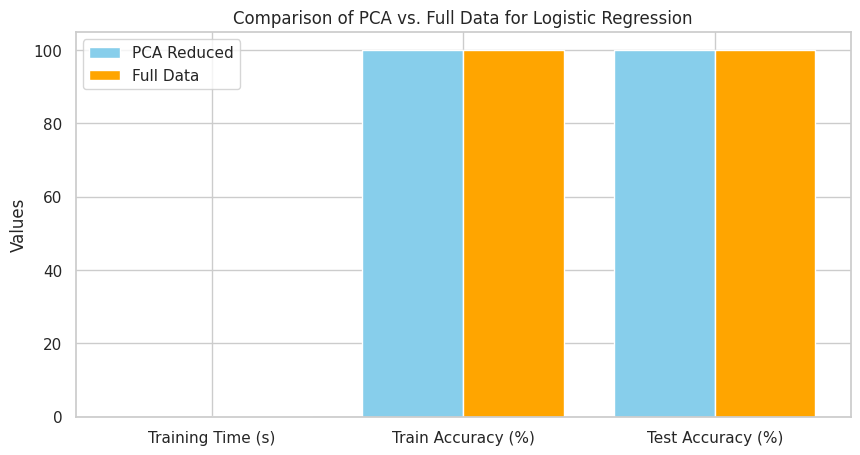

In [ ]:
import matplotlib.pyplot as plt

labels = ['Training Time (s)', 'Train Accuracy (%)', 'Test Accuracy (%)']
pca_values = [logreg_pca_training_time , logreg_pca_train_accuracy * 100, logreg_pca_test_accuracy * 100]
full_values = [lr_training_time , train_accuracy_ls * 100, test_accuracy_ls * 100]

x = range(len(labels))
plt.figure(figsize=(10, 5))
plt.bar(x, pca_values, width=0.4, label='PCA Reduced', color='skyblue', align='center')
plt.bar([i + 0.4 for i in x], full_values, width=0.4, label='Full Data', color='orange', align='center')

plt.title('Comparison of PCA vs. Full Data for Logistic Regression')
plt.xticks([i + 0.2 for i in x], labels)
plt.ylabel('Values')
plt.legend()
plt.show()


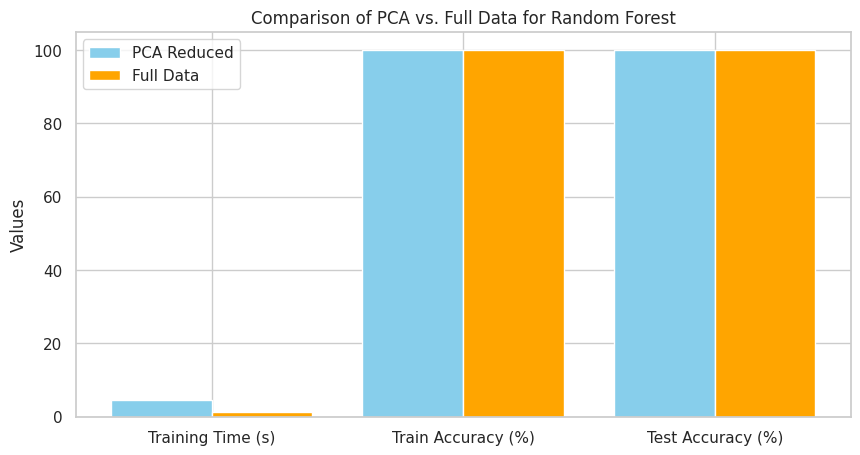

In [ ]:
import matplotlib.pyplot as plt

labels = ['Training Time (s)', 'Train Accuracy (%)', 'Test Accuracy (%)']
pca_values = [rf_pca_training_time , rf_pca_train_accuracy * 100, rf_pca_test_accuracy * 100]
full_values = [rf_training_time , train_accuracy_rf * 100, test_accuracy_rf * 100]

x = range(len(labels))
plt.figure(figsize=(10, 5))
plt.bar(x, pca_values, width=0.4, label='PCA Reduced', color='skyblue', align='center')
plt.bar([i + 0.4 for i in x], full_values, width=0.4, label='Full Data', color='orange', align='center')

plt.title('Comparison of PCA vs. Full Data for Random Forest')
plt.xticks([i + 0.2 for i in x], labels)
plt.ylabel('Values')
plt.legend()
plt.show()


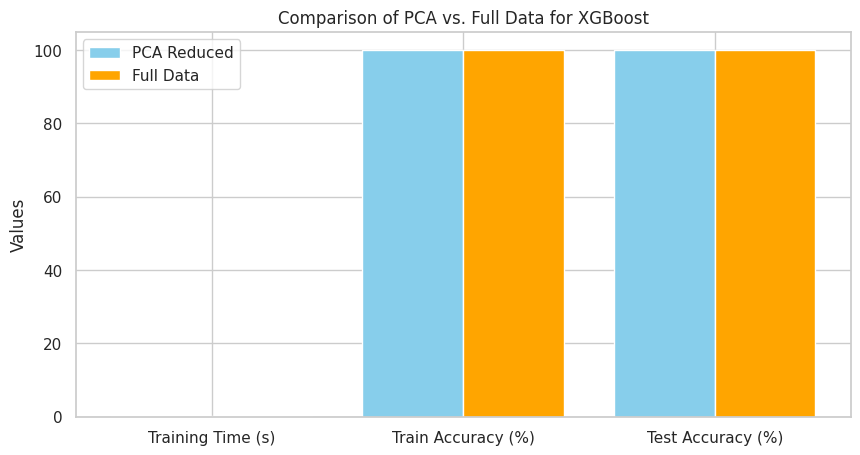

In [ ]:
import matplotlib.pyplot as plt

labels = ['Training Time (s)', 'Train Accuracy (%)', 'Test Accuracy (%)']
pca_values = [xgb_pca_training_time , xgb_pca_train_accuracy * 100, xgb_pca_test_accuracy * 100]
full_values = [xgb_training_time , train_accuracy_xgb * 100, test_accuracy_xgb * 100]

x = range(len(labels))
plt.figure(figsize=(10, 5))
plt.bar(x, pca_values, width=0.4, label='PCA Reduced', color='skyblue', align='center')
plt.bar([i + 0.4 for i in x], full_values, width=0.4, label='Full Data', color='orange', align='center')

plt.title('Comparison of PCA vs. Full Data for XGBoost')
plt.xticks([i + 0.2 for i in x], labels)
plt.ylabel('Values')
plt.legend()
plt.show()


## Prediction

In [ ]:
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
from sklearn.impute import SimpleImputer

def preprocess_data(data, features, target=None):
    if 'player_dismissed' in data.columns:
        data.loc[:, 'wicket'] = data['player_dismissed'].notnull().astype(int)
    else:
        raise ValueError("Error: 'player_dismissed' column is missing from the dataset.")

    data.loc[:, 'rolling_wickets'] = data['wicket'].rolling(window=10).sum()
    data.loc[:, 'collapse'] = (data['rolling_wickets'] >= 3).astype(int)

    data.loc[:, 'runs_off_bat'] = data['runs_off_bat'].fillna(0)

    data.loc[:, 'over'] = data['ball'].apply(lambda x: int(x))
    data.loc[:, 'runs_per_over'] = data['runs_off_bat'] + data['extras']

    data.loc[:, 'batting_team'] = data['batting_team'].astype('category').cat.codes
    data.loc[:, 'bowling_team'] = data['bowling_team'].astype('category').cat.codes

    X = data[features]
    y = data[target] if target else None

    return X, y

features = ['batting_team', 'bowling_team', 'rolling_wickets', 'runs_per_over', 'innings']
target = 'collapse'

old_data = pd.read_csv('deliveries.csv')
new_data = pd.read_csv('updated_deliveries.csv')

X_old, y_old = preprocess_data(old_data, features, target)
X_new, y_new = preprocess_data(new_data, features, target)

overlapping_data = new_data[new_data['match_id'].isin(old_data['match_id'])]
non_overlapping_data = new_data[~new_data['match_id'].isin(old_data['match_id'])]

X_overlap, y_overlap = preprocess_data(overlapping_data, features, target)
X_non_overlap, y_non_overlap = preprocess_data(non_overlapping_data, features, target)

imputer = SimpleImputer(strategy='mean')
X_overlap_imputed = imputer.fit_transform(X_overlap)

smote = SMOTE(random_state=42)
X_overlap_resampled, y_overlap_resampled = smote.fit_resample(X_overlap_imputed, y_overlap)

model = XGBClassifier(scale_pos_weight=len(y_overlap) / sum(y_overlap == 1), use_label_encoder=False, eval_metric='logloss', random_state=42)

print("Training model on resampled overlapping data...")
model.fit(X_overlap_resampled, y_overlap_resampled)

X_non_overlap['batting_team'] = X_non_overlap['batting_team'].astype('category').cat.codes
X_non_overlap['bowling_team'] = X_non_overlap['bowling_team'].astype('category').cat.codes

print("Predicting on non-overlapping data...")
y_pred = model.predict(X_non_overlap)

if y_non_overlap is not None:
    print(f"Accuracy on non-overlapping data: {accuracy_score(y_non_overlap, y_pred):.2f}")
    print("\nConfusion Matrix:")
    print(confusion_matrix(y_non_overlap, y_pred))

non_overlapping_data['Predicted Collapse'] = y_pred
non_overlapping_data.to_csv('predictions_on_new_data.csv', index=False)
print("Predictions saved to 'predictions_on_new_data.csv'.")

print(non_overlapping_data['Predicted Collapse'].unique())
print(non_overlapping_data['Predicted Collapse'].value_counts())


Training model on resampled overlapping data...


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:18:54] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
<ipython-input-269-23610bbb4626>:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_non_overlap['batting_team'] = X_non_overlap['batting_team'].astype('category').cat.codes
<ipython-input-269-23610bbb4626>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_non_overlap['bowling_team'] = X_non_overl

Predicting on non-overlapping data...
Accuracy on non-overlapping data: 1.00

Confusion Matrix:
[[23433     9]
 [    0    37]]
Predictions saved to 'predictions_on_new_data.csv'.
[1 0]
Predicted Collapse
0    23433
1       46
Name: count, dtype: int64


In [ ]:
collapses = non_overlapping_data[non_overlapping_data['Predicted Collapse'] == 1]

collapses['phase_id'] = (collapses['ball'].diff() > 5).cumsum()
collapse_phases = collapses.groupby(['match_id', 'innings', 'phase_id']).agg({
    'ball': ['min', 'max', 'count'],
    'Predicted Collapse': 'size'
}).reset_index()

collapse_phases.columns = ['match_id', 'innings', 'phase_id', 'start_ball', 'end_ball', 'num_balls', 'num_collapses']

collapses.to_csv('collapse_entries.csv', index=False)
collapse_phases.to_csv('collapse_phases.csv', index=False)
print("Collapse entries saved to 'collapse_entries.csv' and grouped phases saved to 'collapse_phases.csv'.")


Collapse entries saved to 'collapse_entries.csv' and grouped phases saved to 'collapse_phases.csv'.


<ipython-input-270-aaf4b1b6543c>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  collapses['phase_id'] = (collapses['ball'].diff() > 5).cumsum()
